# ⚠️ IMPORTANT LEGAL DISCLAIMER

This code is provided for EDUCATIONAL and RESEARCH purposes only.
Song lyrics are the intellectual property of their respective copyright holders.

By using this code, you acknowledge that:
1. You will use the scraped content only for non-commercial, educational analysis
2. You will not redistribute or republish the lyrics
3. You understand that web scraping may violate website terms of service
4. This project falls under Fair Use doctrine for academic research
5. The author of this code is not responsible for any misuse

For production use, please obtain proper licensing through official APIs
or contact the copyright holders directly.

Taylor Swift's lyrics © Taylor Swift and respective publishers

In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import random
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from textblob import TextBlob
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import json
import os
import requests
from bs4 import BeautifulSoup
import time
from difflib import SequenceMatcher 
import pickle
from pyannote.core import Annotation, Segment

## Opening previously preprocessed files
We need to upload diarization and transcription files to create the final segmented variable for analysis.

In [261]:
# =============================================================================
# Extracting diarizations from files
# =============================================================================

# Checking which files are available
save_dir = "saved_diarizations"
if os.path.exists(save_dir):
    files = os.listdir(save_dir)
    print("Found files:")
    for f in files:
        print(f"  - {f}")
else:
    print("Directory not found!")

# Method 1: Loading from pickle (the simplest and fastest)
try:
    pickle_file = os.path.join(save_dir, "podcast_corrected_diarization.pkl")
    with open(pickle_file, 'rb') as f:
        diarization = pickle.load(f)
    print(f"✅ Diarization loaded from pickle!")
    print(f"Number of segments: {len(list(diarization.itertracks()))}")
except Exception as e:
    print(f"❌ Pickle loading error: {e}")
    
    # Method 2: Loading from JSON (if pickle does not work)
    try:
        json_file = os.path.join(save_dir, "podcast_corrected_diarization.json")
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Restoring the Annotation object
        diarization = Annotation()
        for segment_data in data["segments"]:
            segment = Segment(segment_data["start"], segment_data["end"])
            diarization[segment] = segment_data["speaker"]
        
        print(f"✅ Diarization loaded from JSON!")
        print(f"Number of segments: {len(data['segments'])}")
        print(f"Speakers: {data['speakers']}")
    except Exception as e2:
        print(f"❌ JSON loading error: {e2}")

# Checking what has been loaded
if 'diarization' in locals():
    print("\nFirst 5 segments:")
    for i, (turn, _, speaker) in enumerate(diarization.itertracks(yield_label=True)):
        if i >= 5:
            break
        print(f"  {turn.start:.1f}s - {turn.end:.1f}s: {speaker}")

Found files:
  - podcast_corrected_diarization.txt
  - transcription_medium.json
  - podcast_corrected_diarization.json
  - podcast_corrected_diarization.pkl
✅ Diarization loaded from pickle!
Number of segments: 3207

First 5 segments:
  0.0s - 0.3s: Jason Kelsey
  0.9s - 2.3s: Jason Kelsey
  3.3s - 9.0s: Jason Kelsey
  9.2s - 13.1s: Taylor Swift
  10.6s - 11.1s: Jason Kelsey


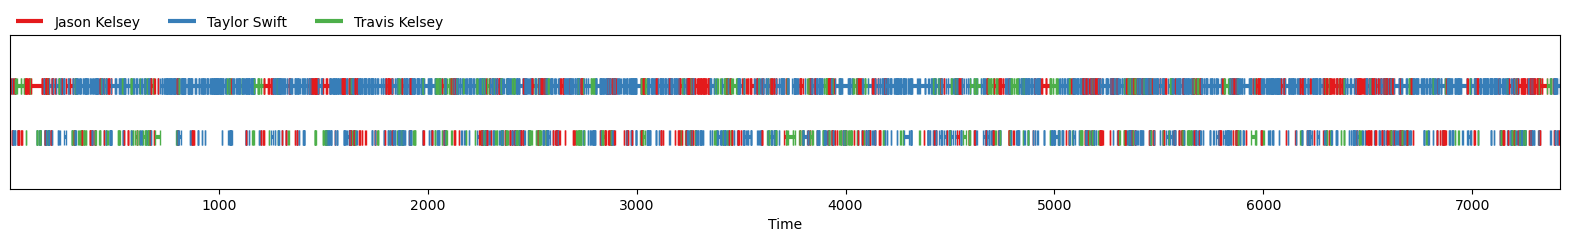

In [11]:
diarization

In [90]:
# =============================================================================
# Load of whisper transcription
# =============================================================================

# Loading transcription
transcription_file = os.path.join("saved_diarizations", "transcription_medium.json")
with open(transcription_file, "r", encoding="utf-8") as f:
    transcription = json.load(f)

print("✅ Transcript loaded!")
print(f"Text: {len(transcription.get('text', ''))} characters")
print(f"Segments: {len(transcription.get('segments', []))}")
print(f"Language: {transcription.get('language', 'unknown')}")

# Showing the first few segments
if 'segments' in transcription:
    print("\nFirst 3 segments:")
    for i, seg in enumerate(transcription['segments'][:3]):
        print(f"{i+1}. [{seg['start']:.1f}s - {seg['end']:.1f}s]: {seg['text'][:100]}...")

✅ Transcript loaded!
Text: 117961 characters
Segments: 2584
Language: en

First 3 segments:
1. [0.0s - 8.2s]:  All right, let's get to the part of this show that I think is what everybody is going to...
2. [8.2s - 9.2s]:  be talking about....
3. [9.2s - 10.2s]:  Do I get to say it?...


## Rebuilding merged segments with corrected speaker names
Once all preprocessed files are uploaded, we can build a variable with merged segments of the final speakers.

In [14]:
# Rebuild merged segments with corrected speaker names

print("[INFO] Rebuilding merged segments with corrected speakers...")

# Clear old merged data and rebuild with corrected diarization
new_merged = []

for seg in transcription["segments"]:
    start, end, text = seg["start"], seg["end"], seg["text"]
    speaker_label = None
    max_overlap = 0
    
    # Find speaker label by maximum overlapping diarization segment
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        # Calculate overlap between transcript segment and diarization segment
        overlap_start = max(start, turn.start)
        overlap_end = min(end, turn.end)
        overlap_duration = max(0, overlap_end - overlap_start)
        
        if overlap_duration > max_overlap:
            max_overlap = overlap_duration
            speaker_label = speaker
    
    new_merged.append({
        "start": start,
        "end": end,
        "text": text.strip(),
        "speaker": speaker_label,
        "overlap_duration": max_overlap
    })

# Replace old merged with new one
merged = new_merged

print("[INFO] Updated merged segments with corrected speaker names")

# Show new statistics
speaker_stats = {}
for segment in merged:
    if segment["speaker"]:
        speaker_stats[segment["speaker"]] = speaker_stats.get(segment["speaker"], 0) + 1

print("[INFO] New merged statistics:")
for speaker, count in sorted(speaker_stats.items()):
    print(f"  {speaker}: {count} segments")

# Show sample of corrected merged data
print("\n[INFO] Sample of corrected merged segments:")
for i, segment in enumerate(merged[:5]):
    print(f"  {i+1}. {segment['speaker']}: \"{segment['text'][:80]}...\"")

print(f"\n[SUCCESS] Merged variable updated with {len(merged)} segments")

[INFO] Rebuilding merged segments with corrected speakers...
[INFO] Updated merged segments with corrected speaker names
[INFO] New merged statistics:
  Jason Kelsey: 588 segments
  Taylor Swift: 1561 segments
  Travis Kelsey: 431 segments

[INFO] Sample of corrected merged segments:
  1. Jason Kelsey: "All right, let's get to the part of this show that I think is what everybody is ..."
  2. Jason Kelsey: "be talking about...."
  3. Taylor Swift: "Do I get to say it?..."
  4. Taylor Swift: "Do I get to say I get to say the two words?..."
  5. Jason Kelsey: "Yes...."

[SUCCESS] Merged variable updated with 2584 segments


## Parsing Songs
| Song                                    | Album                  | Collaborators                     |
| --------------------------------------- |  --------------------- | --------------------------------- |
| 22                                      | Red (2012)             | Max Martin, Shellback             |
| I Knew You Were Trouble                 | Red (2012)             | Max Martin, Shellback             |
| We Are Never Ever Getting Back Together | Red (2012)             | Max Martin, Shellback             |
| Message in a Bottle                     | Red (2012)             | Max Martin, Shellback             |
| Blank Space                             | 1989 (2014)            | Max Martin, Shellback             |
| Style                                   | 1989 (2014)            | Max Martin, Shellback, Ali Payami |
| All You Had To Do Was Stay              | 1989 (2014)            | Max Martin, Shellback             |
| Shake It Off                            | 1989 (2014)            | Max Martin, Shellback             |
| Bad Blood                               | 1989 (2014)            | Max Martin, Shellback             |
| Wildest Dreams                          | 1989 (2014)            | Max Martin, Shellback             |
| How You Get the Girl                    | 1989 (2014)            | Max Martin, Shellback             |
| Wonderland                              | 1989 (2014)            | Max Martin, Shellback             |
| New Romantics                           | 1989 (2014)            | Max Martin, Shellback             |
| …Ready For It?                          | Reputation (2017)      | Max Martin, Shellback             |
| End Game                                | Reputation (2017)      | Max Martin, Shellback             |
| I Did Something Bad                     | Reputation (2017)      | Max Martin, Shellback             |
| Don’t Blame Me                          | Reputation (2017)      | Max Martin, Shellback             |
| Delicate                                | Reputation (2017)      | Max Martin, Shellback             |
| So It Goes…                             | Reputation (2017)      | Max Martin, Shellback             |
| Gorgeous                                | Reputation (2017)      | Max Martin, Shellback             |
| King of My Heart                        | Reputation (2017)      | Max Martin, Shellback             |
| Dancing With Our Hands Tied             | Reputation (2017)      | Max Martin, Shellback             |
| **All 12 tracks (2025)**                | The Life of a Showgirl | Max Martin, Shellback             |

In this table, you can find statistics on all songs that Taylor created in collaboration with Max Martin and Shellback. <br>
For our analysis, we will focus on the <i>Red</i> and <i>1989</i> albums, as according to the podcast, the vibe and mood of the new album will be closest to them. <br>
But first, we need to get lyrics for those songs. <br>
⚠️ Disclaimer: Song lyrics are the property of their respective owners (i.e., Taylor Swift herself).


In [265]:
# We will look into Red & 1989 tracks, as it was promised to have the same vibe
songs = ['22', 'I Knew You Were Trouble', 'We Are Never Ever Getting Back Together', 'Message in a Bottle',
        'Blank Space', 'Style', 'All You Had To Do Was Stay', 'Shake It Off', 'Bad Blood', 'Wildest Dreams', 
        'How You Get the Girl', 'Wonderland', 'New Romantics']

lyrics = {}

for song in tqdm(songs, desc="Fetching lyrics"):
    s_lower = song.replace(" ", "").lower()
    try:
        page_url = f'https://www.azlyrics.com/lyrics/taylorswift/{s_lower}.html'
        page = requests.get(page_url)
        html = BeautifulSoup(page.text, "html.parser")
        
        ringtone_div = html.find('div', class_='ringtone')
        if ringtone_div is None:
            print(f'Lyrics not found for {song}')
            continue
        
        song_title_tag = ringtone_div.find_next('b')
        if song_title_tag is None:
            print(f'Lyrics not found for {song}')
            continue

        lyrics_div = song_title_tag.find_next('div')
        lyric = re.sub(r'\n+', '\n', lyrics_div.get_text(separator="\n").strip()).strip()  

        lyrics[song] = lyric  
        
        time.sleep(np.random.uniform(15, 25))
    except Exception as e:
        print(f'Error for {song}: {e}')

Fetching lyrics:   0%|          | 0/13 [00:00<?, ?it/s]

Lyrics not found for Message in a Bottle


Okay "Message in a Bottle" is From the Vault, so we can skip it.
# Text analysis

### Lyric preprocessing
For clear analysis and understanding of patterns, we first need to process all lines: remove repeated phrases, excessive punctuation, etc.

In [43]:
# =============================================================================
# SONG LYRICS PREPROCESSING
# =============================================================================

cleaned_lyrics = {}  # <- cleared from duplicates etc lyrics

for song_title, lyric_text in lyrics.items():
    if not lyric_text:
        print(f"[WARNING] No lyrics found for {song_title}")
        continue
       
   # Split into lines
    lines = lyric_text.split('\n')

   # Remove duplicates and clean
    unique_lines = []
    seen_lines = set()
   
    for line in lines:
        if line.strip():  # Skip empty lines            
            # Minimal cleaning: lower case + keep natural structure
            line_lower = line.strip().lower()
            processed_line = re.sub(r"[^\w\s'\-,.]", '', line_lower)
            processed_line = ' '.join(processed_line.split())  # Normalize spaces
       
            if not processed_line:  # Skip if empty after cleaning
                continue
       
            if processed_line not in seen_lines:
                # Check if similar line already exists
                is_duplicate = False
                for existing_line in unique_lines:
                    if SequenceMatcher(None, processed_line, existing_line).ratio() >= 0.85:
                        is_duplicate = True
                        break
                if not is_duplicate:
                    unique_lines.append(processed_line)    # Original cleaned version
                    seen_lines.add(processed_line)
       
    cleaned_lyrics[song_title] = unique_lines
    print(f"[INFO] '{song_title}': {len(lines)} lines → {len(unique_lines)} unique lines")
    
print(f"[SUCCESS] Processed {len(cleaned_lyrics)} songs")

[INFO] '22': 77 lines → 38 unique lines
[INFO] 'I Knew You Were Trouble': 52 lines → 26 unique lines
[INFO] 'We Are Never Ever Getting Back Together': 41 lines → 27 unique lines
[INFO] 'Blank Space': 83 lines → 46 unique lines
[INFO] 'Style': 46 lines → 27 unique lines
[INFO] 'All You Had To Do Was Stay': 67 lines → 22 unique lines
[INFO] 'Shake It Off': 74 lines → 32 unique lines
[INFO] 'Bad Blood': 68 lines → 23 unique lines
[INFO] 'Wildest Dreams': 64 lines → 33 unique lines
[INFO] 'How You Get the Girl': 60 lines → 30 unique lines
[INFO] 'Wonderland': 79 lines → 37 unique lines
[INFO] 'New Romantics': 63 lines → 32 unique lines
[SUCCESS] Processed 12 songs


### Podcast preprocessing
We need to make the text format match the cleaned lyrics format. As part of the cleaning, we will remove filler words that are characteristic of conversational speech.

In [44]:
# =============================================================================
# PODCAST PREPROCESSING  
# =============================================================================

# Set up of filler words; will be cautious here so we don't accidentally remove important ones
fillers = r"\b(?:um|uh|uhm|umm|erm|err|eh|ah|oh|hmm|hm|mhm|mmm|huh|yep|nope)\b"

taylor_segments = []  # original Taylor segments with metadata
taylor_texts = []  # processed texts only

for segment in merged:
    speaker = segment.get("speaker")  
    if speaker != 'Taylor Swift':  
        continue 
   
    segment_text = segment.get('text', '')  
    if not segment_text.strip():  # Skip empty segments
        continue
       
    lower_text = segment_text.strip().lower()
    processed_text = re.sub(r"[^\w\s'\-,.]", '', lower_text)
    processed_text = re.sub(fillers, '', processed_text)
    processed_line = re.sub(r"\s+", " ", processed_text).strip()  # Normalize spaces
   
    if processed_line:  # Only add non-empty texts
        taylor_texts.append(processed_line)
        segment["processed_line"] = processed_line
   
    taylor_segments.append(segment)

print(f"[SUCCESS] Extracted {len(taylor_segments)} segments from Taylor Swift")
print(f"[SUCCESS] Generated {len(taylor_texts)} processed text segments")

[SUCCESS] Extracted 1561 segments from Taylor Swift
[SUCCESS] Generated 1561 processed text segments


### Creating a mathematical profile of song style
To understand which phrases spoken in the podcast could be teasers for new song lyrics, we need to extract the lyrical pattern first. <br>
This approach will include:
- TF-IDF Analysis
- N-gram Analysis: 3–4-word phrases and 2-word bigrams
- Lyrical Style Metrics: line length and word repetition
- TextBlob Analysis
- Sentence Transformers Analysis with the 'all-mpnet-base-v2' model

In [227]:
# =============================================================================
# STAGE 1: Extract Lyrical Patterns from Songs 
# =============================================================================

# Start with combining all song lyrics into one list
all_song_lines = []
song_line_mapping = []  # Track which song each line came from [in case it will be needed later]

for song_title, lines in cleaned_lyrics.items():
    for line in lines:
        all_song_lines.append(line)
        song_line_mapping.append(song_title)


# 1. TF-IDF Analysis - Find Most Important Words

tfidf_vectorizer = TfidfVectorizer(
   max_features=1000,
   ngram_range=(1, 1),  # Start with single words first
   min_df=2,  # Must appear in at least 2 lines
   max_df=0.8,  # If word in 80%+ of lines -- do not include
   stop_words='english'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(all_song_lines)
feature_words = tfidf_vectorizer.get_feature_names_out()

# Calculating TF-IDF score for each word left after filtration
mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
centroid_vector = mean_scores.reshape(1, -1)

# Top-100 signature words
top_word_indices = np.argsort(mean_scores)[-100:][::-1] 
signature_words = [(feature_words[idx], mean_scores[idx]) for idx in top_word_indices]

print('Top-20 Taylor Swift signature words from Rep+1989 with Max Martin & Shellback:')
for i, (word, score) in enumerate(signature_words[:20]):
    print(f" {i+1:2d}. {word:15} (score: {score:.4f})")


# =============================================================================
# 2. N-gram Analysis - Find Characteristic Phrases  

ngram_vectorizer = CountVectorizer(
   ngram_range=(3, 4),  # phrases of 3-4 words
   max_features=500, 
   min_df=2,  # Must appear in at least 2 lines
   lowercase=True,  # We already have lower case, but just in case
   stop_words=['oh', 'uh', 'fake', 'shake', 'eh', 'ooh', 'yeah', 'hate']  
)

ngram_matrix = ngram_vectorizer.fit_transform(all_song_lines)
ngram_feature_phrases = ngram_vectorizer.get_feature_names_out()
ngram_count = np.array(ngram_matrix.sum(axis=0)).flatten()

# Top-50 signature phrases
top_phrases_indices = np.argsort(ngram_count)[-50:][::-1]
signature_phrases = [(ngram_feature_phrases[idx], ngram_count[idx]) for idx in top_phrases_indices]

print('\n\nTop characteristic phrases from Rep+1989 with Max Martin & Shellback:')
for i, (phrase, count) in enumerate(signature_phrases[:20]):
    print(f" {i+1:2d}. '{phrase}' (appears {int(count)} times)")


# =============================================================================
# 3. Lyrical Style Metrics

# Line length analysis
line_lengths = [len(line.split()) for line in all_song_lines]
avg_line_length = np.mean(line_lengths)
std_line_length = np.std(line_lengths)

# Word repetition analysis
all_words = []
for line in all_song_lines:
    all_words.extend(line.split())
    
word_freq = Counter(all_words)
most_repeated = word_freq.most_common(20)

print("\n\nStyle metrics:")
print(f" Average line length: {avg_line_length:.1f} words")
print(f" Line length variation: {std_line_length:.1f}")
print(f" Total unique words: {len(word_freq)}")
print(f" Most repeated words: {[word for word, count in most_repeated]}")


# =============================================================================
# 4. Sentiment Pattern Analysis using TextBlob

song_sentiments = []
for line in all_song_lines:
    blob = TextBlob(line)
    song_sentiments.append({
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity
    })

avg_song_polarity = np.mean([s['polarity'] for s in song_sentiments])
avg_song_subjectivity = np.mean([s['subjectivity'] for s in song_sentiments])
std_song_polarity = np.std([s['polarity'] for s in song_sentiments])
std_song_subjectivity = np.std([s['subjectivity'] for s in song_sentiments])

print(f"\nSentiment patterns in songs:")
print(f" Average polarity: {avg_song_polarity:.3f} (±{std_song_polarity:.3f})")
print(f" Average subjectivity: {avg_song_subjectivity:.3f} (±{std_song_subjectivity:.3f})")

# =============================================================================
# 5. Bigram Analysis for Common Word Pairs

bigram_vectorizer = CountVectorizer(
   ngram_range=(2, 2),
   max_features=100,
   min_df=2,
   stop_words=['oh', 'uh', 'fake', 'shake', 'eh', 'ooh', 'yeah', 'hate'] 
)

bigram_matrix = bigram_vectorizer.fit_transform(all_song_lines)
bigram_features = bigram_vectorizer.get_feature_names_out()
bigram_counts = np.array(bigram_matrix.sum(axis=0)).flatten()

top_bigram_indices = np.argsort(bigram_counts)[-30:][::-1]
signature_bigrams = [(bigram_features[idx], bigram_counts[idx]) for idx in top_bigram_indices]

print("\nTop word pairs (bigrams):")
for i, (bigram, count) in enumerate(signature_bigrams[:15]):
    print(f" {i+1:2d}. '{bigram}' ({int(count)} times)")

# =============================================================================
# 6. Sentence Transformers Analysis

model_name = 'sentence-transformers/all-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Breakdown batches by songs
song_indices = [0]
for i in tqdm(range(1, len(song_line_mapping)), desc='Embedding songs'):
    if song_line_mapping[i] != song_line_mapping[i-1]:
        song_indices.append(i)
song_indices.append(len(song_line_mapping))

embeddings = []

for i, j in enumerate(song_indices):
    if i == 0:
        continue
    batch_lines = all_song_lines[song_indices[i-1]:j]
    
    # Tokenize
    encoded = tokenizer(
        batch_lines, 
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**encoded)
        attention_mask = encoded['attention_mask']
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        batch_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
                            input_mask_expanded.sum(1), min=1e-9)
    
    embeddings.extend(batch_embeddings.numpy())


song_embeddings = np.array(embeddings) 

# Calculating statistics for the stylistic space of songs
song_centroid = np.mean(song_embeddings, axis=0)
song_std = np.std(song_embeddings, axis=0)

print(f"Song embeddings shape: {song_embeddings.shape}")

Top-20 Taylor Swift signature words from Rep+1989 with Max Martin & Shellback:
  1. like            (score: 0.0469)
  2. oh              (score: 0.0379)
  3. know            (score: 0.0274)
  4. say             (score: 0.0274)
  5. got             (score: 0.0252)
  6. ooh             (score: 0.0241)
  7. yeah            (score: 0.0224)
  8. ll              (score: 0.0224)
  9. don             (score: 0.0209)
 10. just            (score: 0.0208)
 11. ve              (score: 0.0207)
 12. time            (score: 0.0178)
 13. cause           (score: 0.0175)
 14. want            (score: 0.0174)
 15. hey             (score: 0.0173)
 16. love            (score: 0.0169)
 17. think           (score: 0.0156)
 18. come            (score: 0.0144)
 19. girl            (score: 0.0144)
 20. forever         (score: 0.0141)


Top characteristic phrases from Rep+1989 with Max Martin & Shellback:
  1. 'don know about' (appears 6 times)
  2. 'get the girl' (appears 5 times)
  3. 'got lost in' (appears 4 t

Embedding songs:   0%|          | 0/372 [00:00<?, ?it/s]

Song embeddings shape: (373, 768)


### Defining lyrical segments in podcast
We will calculate similar metrics for podcast segments and build a similarity score, adjusted for segment length.

In [228]:
# =============================================================================
# STAGE 2: Find Lyrical Segments in Podcast
# =============================================================================

top_words = set([word for word, score in signature_words])  # Top 100 words
top_phrases = [phrase for phrase, count in signature_phrases]  # Top 50 phrases
top_bigrams = [bigram for bigram, count in signature_bigrams]  # Top 30 bigrams

scored_segments = []
for segment in tqdm(taylor_segments, desc='Processing segments'):
    
    text = segment.get('processed_line', '')
   
    if not text or len(text.split()) < 3:  # Skip very short segments
        continue
   
    scores = {}
# =============================================================================
# 1. TF-IDF Similarity Score

    try:
        segment_tfidf = tfidf_vectorizer.transform([text])
        tfidf_similarity = cosine_similarity(segment_tfidf, centroid_vector)[0, 0]
        scores['tfidf_score'] = tfidf_similarity  
    except Exception as e:
        scores['tfidf_score'] = 0.0

# =============================================================================
# 2. Signature Word Matching Score
   
    segment_words = set(text.split())
    word_matches = len(segment_words.intersection(top_words))
    scores['word_match_score'] = word_matches / max(1, len(segment_words))  

# =============================================================================
# 3. Phrase Matching Score
    
    phrase_matches = sum(1 for phrase in top_phrases if phrase in text)
    scores['phrase_match_score'] = phrase_matches / max(1, len(top_phrases))

# =============================================================================
# 4. Bigram Matching Score 

    bigram_matches = sum(1 for bigram in top_bigrams if bigram in text)
    scores['bigram_match_score'] = bigram_matches / max(1, len(top_bigrams))

# =============================================================================
# 5. Style Similarity Score

    segment_length = len(text.split())
    if avg_line_length > 0:  
        length_similarity = 1.0 - abs(segment_length - avg_line_length) / avg_line_length
        length_similarity = max(0, min(1, length_similarity))  # Clamp to [0, 1]
    else:
        length_similarity = 0
    
    scores['style_score'] = length_similarity

# =============================================================================
# 6. Repetition Score [lyrics often have repetitive words]
   
    segment_word_freq = Counter(text.split())
    if len(segment_word_freq) > 0:  
        repetition_score = sum(1 for word, count in segment_word_freq.items() if count > 1)/len(segment_word_freq)
    else:
        repetition_score = 0
        
    scores['repetition_score'] = repetition_score

# =============================================================================
# 7. Sentiment Similarity Score 

    blob = TextBlob(text)
    polarity_diff = abs(blob.sentiment.polarity - avg_song_polarity)
    subjectivity_diff = abs(blob.sentiment.subjectivity - avg_song_subjectivity)
    sentiment_similarity = 1 - (polarity_diff + subjectivity_diff) / 2
    scores['sentiment_score'] = max(0, sentiment_similarity)

# =============================================================================
# 8. Question/Exclamation Pattern Score 
    
    has_question = '?' in segment.get('text', '')
    has_exclamation = '!' in segment.get('text', '')
    punctuation_score = 0.3 if has_question else 0
    punctuation_score += 0.3 if has_exclamation else 0
    scores['punctuation_score'] = punctuation_score
    
    
# =============================================================================  
# 9. Sentence-Transformers analysis

    encoded = tokenizer(
        text, 
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**encoded)
        attention_mask = encoded['attention_mask']
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        text_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
                                                        input_mask_expanded.sum(1), min=1e-9)

    segment_embedding = text_embeddings.numpy()[0]
    
    # Centroid similarity
    scores['centroid_similarity'] = cosine_similarity(
        segment_embedding.reshape(1, -1),
        song_centroid.reshape(1, -1)
    )[0, 0]
    
    # Style similarity
    distances = np.array([np.linalg.norm(segment_embedding - song_emb) 
                          for song_emb in song_embeddings
                         ])
    closest_5_indices = np.argsort(distances)[:5]
    avg_distance_to_neighbors = np.mean(distances[closest_5_indices])
    scores['style_similarity'] = 1 / (1 + avg_distance_to_neighbors)

# =============================================================================
# 10. Adaptive Weights based on segment length 

    if segment_length < 5:
        weights = {
            'tfidf_score': 0.10,
            'word_match_score': 0.30,
            'centroid_similarity': 0.20,
            'style_similarity': 0.10,
            'bigram_match_score': 0.00,
            'phrase_match_score': 0.00,
            'style_score': 0.10,
            'repetition_score': 0.05,
            'sentiment_score': 0.10,
            'punctuation_score': 0.05
        }
    elif segment_length > 20:
        weights = {
            'tfidf_score': 0.30,
            'word_match_score': 0.10,
            'centroid_similarity': 0.30,
            'style_similarity': 0.20,
            'bigram_match_score': 0.00,
            'phrase_match_score': 0.00,
            'style_score': 0.00,
            'repetition_score': 0.00,
            'sentiment_score': 0.05,
            'punctuation_score': 0.05
        }
    else:
        weights = {
            'tfidf_score': 0.20,
            'word_match_score': 0.15,
            'centroid_similarity': 0.25,
            'style_similarity': 0.15,
            'bigram_match_score': 0.00,
            'phrase_match_score': 0.00,
            'style_score': 0.10,
            'repetition_score': 0.05,
            'sentiment_score': 0.05,
            'punctuation_score': 0.05
        }

# =============================================================================
    # Calculate combined score
    combined_score = sum(scores.get(key, 0) * weights.get(key, 0) for key in weights)
    scores['combined_score'] = combined_score

    # Saving Results
    result = segment.copy()
    result.update(scores)
    scored_segments.append(result)

# =============================================================================
# Sort by combined score
scored_segments.sort(key=lambda x: x['combined_score'], reverse=True)

# Filter out low-quality results
filtered_segments = []
for segment in scored_segments:
    if (segment['combined_score'] >= 0.25 and  # Minimum threshold
        #segment['tfidf_score'] > 0.05 and  # Some TF-IDF similarity
        len(segment.get('processed_line', '').split()) >= 4):  # Minimum length
        filtered_segments.append(segment)

print("="*60)
print("TOP POTENTIALLY LYRICAL SEGMENTS")
print("="*60)
for i, segment in enumerate(filtered_segments[:15]):
    print(f"\n🏆 RANK #{i+1}")
    print(f"⭐ SCORE: {segment['combined_score']:.3f}")
    print(f"⏱️  TIME: {segment.get('start', 0):.1f}s - {segment.get('end', 0):.1f}s")
    print(f"📝 TEXT: \"{segment.get('text', '')}\"")
    print(f"📊 BREAKDOWN:")
    print(f"   TF-IDF: {segment.get('tfidf_score', 0):.3f} | Words: {segment.get('word_match_score', 0):.3f}")
    print(f"   Centroid: {segment.get('centroid_similarity', 0):.3f} | Style Similarity: {segment.get('style_similarity', 0):.3f}")
    print(f"   Style: {segment.get('style_score', 0):.3f} | Sentiment: {segment.get('sentiment_score', 0):.3f}")
    print("-" * 50)

# Statistics about results
print(f"\n📈 ANALYSIS STATISTICS:")
print(f"Total segments analyzed: {len(taylor_segments)}")
print(f"Segments with scores: {len(scored_segments)}")
print(f"High-quality matches: {len(filtered_segments)}")
print(f"Average score of top 10: {np.mean([s['combined_score'] for s in filtered_segments[:10]]):.3f}")

Processing segments:   0%|          | 0/1561 [00:00<?, ?it/s]

TOP POTENTIALLY LYRICAL SEGMENTS

🏆 RANK #1
⭐ SCORE: 0.425
⏱️  TIME: 1047.6s - 1049.6s
📝 TEXT: "And you come up and I'm just like."
📊 BREAKDOWN:
   TF-IDF: 0.348 | Words: 0.286
   Centroid: 0.523 | Style Similarity: 0.270
   Style: 0.894 | Sentiment: 0.895
--------------------------------------------------

🏆 RANK #2
⭐ SCORE: 0.420
⏱️  TIME: 3757.2s - 3760.2s
📝 TEXT: "People went down like"
📊 BREAKDOWN:
   TF-IDF: 0.199 | Words: 0.500
   Centroid: 0.409 | Style Similarity: 0.253
   Style: 0.553 | Sentiment: 0.876
--------------------------------------------------

🏆 RANK #3
⭐ SCORE: 0.409
⏱️  TIME: 2710.2s - 2711.2s
📝 TEXT: "Like I play instruments."
📊 BREAKDOWN:
   TF-IDF: 0.256 | Words: 0.500
   Centroid: 0.325 | Style Similarity: 0.239
   Style: 0.553 | Sentiment: 0.895
--------------------------------------------------

🏆 RANK #4
⭐ SCORE: 0.406
⏱️  TIME: 378.6s - 380.6s
📝 TEXT: "It's just like it's just like, it's about it."
📊 BREAKDOWN:
   TF-IDF: 0.362 | Words: 0.333
   Centroid:

The final weights for phrases were eventually set to zero, as the analysis showed inefficiency of those two metrics. Still, it was fun to explore these patterns. <br>
Ultimately, we built a TS song pattern profile, which correctly identified the phrase <i>"Baby, just say yeast."</i> — a funny baking wordplay on a previous album lyric (not used in training, as it is from the Fearless era).
In my humble opinion, a few more phrases were interesting: <i>"He's just like he's just a maniac"</i>, <i>"And he's like, I got you."</i>, <i>"Like I play instruments."</i> <br>
While these are unlikely to be lyrics from the next album, they definitely show that Taylor, when happy and excited, speaks rhythmically and in a style reminiscent of her bright pop eras.

# Fine-tune
We have built a lyric profile and observed that TS’s speech is very rhythmic, making it hard to pinpoint where the real Easter eggs are. <br>
The Life of a Showgirl announcement podcast session starts at 1:25:36, and the album details session ends at 1:46:06. So let's assume that all Easter eggs and potential lyrics are within this segment, while the rest of the show can be used as training material.

In [226]:
# Let's calculate start and end time in seconds
start_time = (60+25)*60 + 36
end_time = (60+46)*60 + 6

album_segments = []
podcast_segments = []

for segment in taylor_segments:
    if start_time <= segment.get('start', 0) < end_time:
        album_segments.append(segment)
    else:
        podcast_segments.append(segment)

print(f"Defined {len(album_segments)} segments from Album session")
print(f"Defined {len(podcast_segments)} segments from podcast talk")
print(f"\n\nThere are {len(all_song_lines)} song lines availible for analysis")

Defined 293 segments from Album session
Defined 1268 segments from podcast talk


There are 373 song lines availible for analysis


We will train a classifier to distinguish podcast phrases from potential song lyrics using a Triplet Loss approach.
To avoid overfitting, we will split our sample into train/test sets.

In [270]:
# We already uploaded the 'all-mpnet-base-v2' model from sentence-transformers.  
# Let's create a function to use it, as we will need it repeatedly in this section.

def get_sentence_embedding(texts):
    if isinstance(texts, str):
        texts = [texts]
    
    embeddings = []
        
    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    
    with torch.no_grad():
        outputs = model(**encoded)
        attention_mask = encoded['attention_mask']
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
                            input_mask_expanded.sum(1), min=1e-9)
    
    return embeddings.numpy()


# Define Style Classifier 

class StyleClassifier(nn.Module):
    """Classifier for determining song style"""
    def __init__(self, input_dim=768):
        super().__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_dim, 128),  # упростили
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32)
        )
        
    def forward(self, x):
        return self.transform(x)

style_classifier = StyleClassifier()
optimizer = torch.optim.Adam(style_classifier.parameters(), lr=1e-3)


# Training data preparation
positive_pairs = []
negative_pairs = []

# Positive pairs (lines from songs)
for i in range(len(all_song_lines)):
    if i in song_indices:
        continue
    else:
        positive_pairs.append((all_song_lines[i-1], all_song_lines[i]))

# Negative pairs (song vs podcast)
podcast_samples = [s.get('processed_line', '') 
                  for s in random.sample(podcast_segments, len(all_song_lines))]

for i in range(len(podcast_samples)):
    if i in song_indices:
        continue
    else:
        negative_pairs.append((all_song_lines[i], podcast_samples[i]))

print(f"Created {len(positive_pairs)} positive pairs and {len(negative_pairs)} negative pairs")

# Train-Test Split
# Combine pairs with labels for splitting
all_pairs = [(p, 1) for p in positive_pairs] + [(n, 0) for n in negative_pairs]
random.shuffle(all_pairs)

train_pairs, test_pairs = train_test_split(all_pairs, test_size=0.2,
                                           random_state=42,
                                           stratify=[x[1] for x in all_pairs])

train_positive = [p[0] for p in train_pairs if p[1] == 1]
train_negative = [p[0] for p in train_pairs if p[1] == 0]
test_positive = [p[0] for p in test_pairs if p[1] == 1]  
test_negative = [p[0] for p in test_pairs if p[1] == 0]

print(f"Train: {len(train_positive)} positive, {len(train_negative)} negative")
print(f"Test: {len(test_positive)} positive, {len(test_negative)} negative")

batch_size = 32
num_epochs = 5 

# Training loop
for epoch in range(num_epochs):
    style_classifier.train()
    total_loss = 0
    num_batches = 0
    
    min_pairs = min(len(train_positive), len(train_negative))
    
    for i in range(0, min_pairs, batch_size):
        batch_end = min(i+batch_size, min_pairs)
    
        # Pairs
        pos_batch = train_positive[i:batch_end]
        neg_batch = train_negative[i:batch_end]
    
        if len(pos_batch) == 0 or len(neg_batch) == 0:
            continue
    
        # Get text
        anchors = [p[0] for p in pos_batch]
        positives = [p[1] for p in pos_batch]
        negatives = [n[1] for n in neg_batch]
    
        # Get embedding
        try:
            anchor_emb = get_sentence_embedding(anchors)
            positive_emb = get_sentence_embedding(positives)
            negative_emb = get_sentence_embedding(negatives)
        
            if anchor_emb.shape[0] != positive_emb.shape[0] or anchor_emb.shape[0] != negative_emb.shape[0]:
                print(f"Skipping batch due to size mismatch")
                continue
        
            # To tensors
            anchor_tensor = torch.FloatTensor(anchor_emb)
            positive_tensor = torch.FloatTensor(positive_emb)
            negative_tensor = torch.FloatTensor(negative_emb)
        
            # Applying Classification
            anchor_style = style_classifier(anchor_tensor)
            positive_style = style_classifier(positive_tensor)
            negative_style = style_classifier(negative_tensor)
        
            # Calculating triplet loss
            pos_dist = F.pairwise_distance(anchor_style, positive_style)
            neg_dist = F.pairwise_distance(anchor_style, negative_style)
            loss = F.relu(pos_dist - neg_dist + 1.0).mean()
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item()
            num_batches += 1
        
        except Exception as e:
            print(f"Error in batch {i//batch_size}: {e}")
            continue
    
    if num_batches > 0:
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}")
    else:
        print(f"Epoch {epoch+1}/{num_epochs}, No valid batches")

# Test evaluation
style_classifier.eval()
test_losses = []

print("\n🧪 Testing phase...")
min_test_pairs = min(len(test_positive), len(test_negative))

for i in range(0, min_test_pairs, batch_size):
    batch_end = min(i+batch_size, min_test_pairs)
    
    pos_batch = test_positive[i:batch_end]
    neg_batch = test_negative[i:batch_end]
    
    if len(pos_batch) == 0 or len(neg_batch) == 0:
        continue
    
    anchors = [p[0] for p in pos_batch]
    positives = [p[1] for p in pos_batch]
    negatives = [n[1] for n in neg_batch]
    
    try:
        anchor_emb = get_sentence_embedding(anchors)
        positive_emb = get_sentence_embedding(positives)
        negative_emb = get_sentence_embedding(negatives)
        
        if anchor_emb.shape[0] != positive_emb.shape[0] or anchor_emb.shape[0] != negative_emb.shape[0]:
            continue
        
        anchor_tensor = torch.FloatTensor(anchor_emb)
        positive_tensor = torch.FloatTensor(positive_emb)
        negative_tensor = torch.FloatTensor(negative_emb)
        
        with torch.no_grad():
            anchor_style = style_classifier(anchor_tensor)
            positive_style = style_classifier(positive_tensor)
            negative_style = style_classifier(negative_tensor)
            
            pos_dist = F.pairwise_distance(anchor_style, positive_style)
            neg_dist = F.pairwise_distance(anchor_style, negative_style)
            test_loss = F.relu(pos_dist - neg_dist + 1.0).mean()
            test_losses.append(test_loss.item())
    
    except Exception as e:
        print(f"Error in test batch: {e}")
        continue

if test_losses:
    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"📊 Test Loss: {avg_test_loss:.4f}")
else:
    print("⚠️ No valid test batches")

print("✅ Training complete!") 


Created 361 positive pairs and 361 negative pairs
Train: 289 positive, 288 negative
Test: 72 positive, 73 negative
Epoch 1/5, Train Loss: 0.9742
Epoch 2/5, Train Loss: 0.8160
Epoch 3/5, Train Loss: 0.5311
Epoch 4/5, Train Loss: 0.2755
Epoch 5/5, Train Loss: 0.1792

🧪 Testing phase...
📊 Test Loss: 0.2474
✅ Training complete!


We will then create benchmark song embeddings, a BERT centroid, and a song style centroid based on the benchmark training data and save the trained classifier.
This will allow us to reproduce the research later.

In [272]:
train_song_lines = []

for pair in train_positive:  # ← TRAIN data!
    anchor, positive = pair
    train_song_lines.append(anchor)
    train_song_lines.append(positive)

train_song_lines = list(set(train_song_lines))
train_song_embeddings = get_sentence_embedding(train_song_lines)
train_song_centroid_bert = np.mean(train_song_embeddings, axis=0)

train_song_tensor = torch.FloatTensor(train_song_embeddings)
with torch.no_grad():
    train_song_style_features = style_classifier(train_song_tensor)
song_style_centroid = train_song_style_features.mean(dim=0).numpy() 


# Saving trained model with song_style_centroid and train_song_centroid_bert
torch.save({
    'model_state_dict': style_classifier.state_dict(),
    'song_style_centroid': song_style_centroid,  
    'train_song_centroid_bert': train_song_centroid_bert,
}, 'style_classifier_model.pth')

print("✅ Model saved!")

✅ Model saved!


In [ ]:
# This code allows uploading the trained model, which is essential to reproduce the same results, 
# as training cannot be exactly repeated.
class StyleClassifier(nn.Module):
    """Classifier for determining song style"""
    def __init__(self, input_dim=768):
        super().__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_dim, 128),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32)
        )
        
    def forward(self, x):
        return self.transform(x)
    
style_classifier = StyleClassifier(input_dim=768)
optimizer = torch.optim.Adam(style_classifier.parameters(), lr=1e-3)

# Loading trained model
checkpoint = torch.load('style_classifier_model.pth')
style_classifier.load_state_dict(checkpoint['model_state_dict'])
song_style_centroid = checkpoint['song_style_centroid']
train_song_centroid_bert = checkpoint['train_song_centroid_bert']

style_classifier.eval()
print("✅ Model loaded!")

### Easter Eggs Analysis
Let's use this approach to find potential lyrics!

In [273]:
scored_segments_bert = []

for segment in tqdm(album_segments, desc='Processing Album segments'):
    
    text = segment.get('processed_line', '')
   
    if not text or len(text.split()) < 3:  # Skip very short segments
        continue
    
    try:
        embeddings = get_sentence_embedding(text)
        
        with torch.no_grad():
            emb_tensor = torch.FloatTensor(embeddings)
            style_features = style_classifier(emb_tensor)
            
        bert_similarity = cosine_similarity(
            embeddings.reshape(1, -1),
            train_song_centroid_bert.reshape(1, -1)
        )[0][0]
        
        style_vector = style_features.numpy()[0]  # [0] because it's one element batch
        style_similarity = cosine_similarity(
            style_vector.reshape(1, -1),
            song_style_centroid.reshape(1, -1)  # Comparison with style centroid
        )[0][0]        
        
        result = segment.copy()
        result['bert_similarity'] = bert_similarity
        result['style_similarity'] = style_similarity
        scored_segments_bert.append(result)
        
    except Exception as e:
        print(f"Error processing segment: {e}")

scored_segments_bert.sort(key=lambda x: x['style_similarity'], reverse=True)

print("\n" + "="*60)
print("🎵 TOP LYRICAL SEGMENTS")
print("="*60)

for i, segment in enumerate(scored_segments_bert[:15]):
    style = segment['style_similarity']
    similarity = segment['bert_similarity']
    
    print(f"\n🎶 RANK #{i+1}")
    print(f"⭐ Style Similarity: {style:.3f}")
    print(f"🎯 BERT Similarity: {similarity:.3f}")
    print(f"⏱️ Time: {segment.get('start', 0):.1f}s - {segment.get('end', 0):.1f}s")
    print(f"💬 Text: \"{segment.get('text', '')}\"")
    print("-" * 50)

print(f"\n✅ Analysis complete! Processed {len(scored_segments_bert)} segments.")

Processing Album segments:   0%|          | 0/293 [00:00<?, ?it/s]


🎵 TOP LYRICAL SEGMENTS

🎶 RANK #1
⭐ Style Similarity: 0.942
🎯 BERT Similarity: 0.384
⏱️ Time: 6255.1s - 6256.1s
💬 Text: "But you did it tonight."
--------------------------------------------------

🎶 RANK #2
⭐ Style Similarity: 0.939
🎯 BERT Similarity: 0.424
⏱️ Time: 5351.6s - 5352.5s
💬 Text: "So we got all..."
--------------------------------------------------

🎶 RANK #3
⭐ Style Similarity: 0.935
🎯 BERT Similarity: 0.242
⏱️ Time: 5438.0s - 5446.2s
💬 Text: "Last track, track 12, the title track, The Life of a Showgirl featuring Sabrina Carpenter."
--------------------------------------------------

🎶 RANK #4
⭐ Style Similarity: 0.930
🎯 BERT Similarity: 0.466
⏱️ Time: 5573.1s - 5573.6s
💬 Text: "Do you know what I mean?"
--------------------------------------------------

🎶 RANK #5
⭐ Style Similarity: 0.915
🎯 BERT Similarity: 0.395
⏱️ Time: 5509.9s - 5513.1s
💬 Text: "We did We Are Never Getting Back Together, I Knew You Were Trouble, 22,"
------------------------------------------------

Looking at the results: <br>
Some song titles were recognized as potential lyrics, which makes sense, since titles are often part of the lyrics.
Of the 12 titles, the most highlighted were: <i>"Actually Romantic" </i>, <i>"Ruin the Friendship"</i>, <i>"The Life of a Showgirl"</i>. I believe these will definitely stand out on the album.<br>

As for potential lyrics or Easter eggs, we may have heard something related to: <i>"end of my night"</i>, <i>"there's a poem in this"</i> and hopfully <i>"Life is more upbeat"</i>. But we'll see on October 3rd. <br>

It's definitely fun to dive deeply into the lyrics and artistry of a favorite artist. The next step could be connecting large LLM APIs to generate lyrics inspired by the found materials — but honestly, I doubt AI can recreate the artistry of someone who wrote a line like "Cause something counterfeit's dead."